In [114]:
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ExponentialLR
from torchinfo import summary
from sklearn.model_selection import train_test_split

In [1]:
from training.youtube import *
from training.prepare import *
from training.model_wrapper import *
from training.train_metrics import *
from dataset import *
from model import *

# Пайплайн данных

### Загрузка аудио

In [ ]:
download_audio_from_youtube('/Users/igorfrolkin/Downloads/ava_video_list_v1.0.txt','/Users/igorfrolkin/Downloads/ava_sounds_2')

In [ ]:
convert_audio_to_wav('/Users/igorfrolkin/Downloads/ava_sounds_2', '/Users/igorfrolkin/Downloads/ava_sounds_2/wav')

In [71]:
dataset_to_abs_path('/Users/igorfrolkin/Downloads/ava_speech_labels_v1.csv', '/Users/igorfrolkin/Downloads/ava_sounds_2/wav')

### Подготовка спектрограмм

In [ ]:
labels = create_spec_dataset('/Users/igorfrolkin/Downloads/ava_speech_labels_v1.csv',
                    '/Users/igorfrolkin/Downloads/ava_spec_2', ',')

In [45]:
np.save('/Users/igorfrolkin/Downloads/labels_2', labels)

### Подготовка датасетов для обучения и тестов

In [46]:
train_df, test_df = create_train_test_dataset(labels)
train_df.head()

,spec_paths,labels
0,/Users/igorfrolkin/Downloads/ava_spec_2/Ag-pXi...,1
1,/Users/igorfrolkin/Downloads/ava_spec_2/N1K2bE...,1
2,/Users/igorfrolkin/Downloads/ava_spec_2/plkJ45...,1
3,/Users/igorfrolkin/Downloads/ava_spec_2/2bxKkU...,0
4,/Users/igorfrolkin/Downloads/ava_spec_2/qx2vAO...,0


In [47]:
print(f'Images for train: {train_df.shape[0]}, images for test: {test_df.shape[0]}')

Images for train: 176934, images for test: 44234


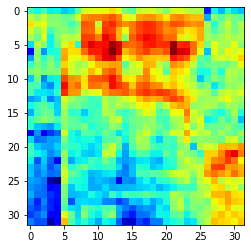

1


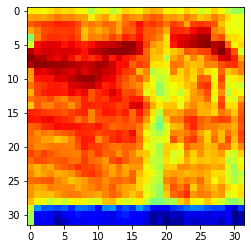

1


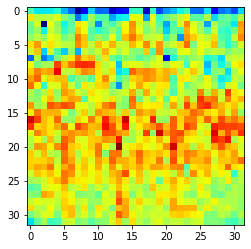

0


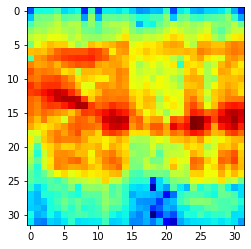

1


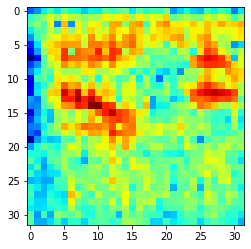

1


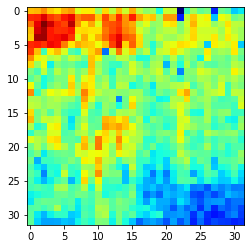

0


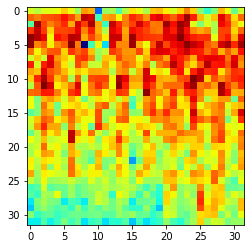

0


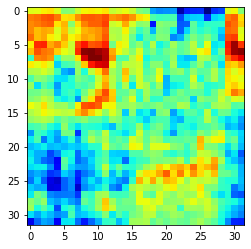

1


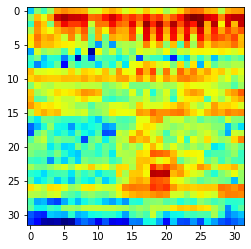

0


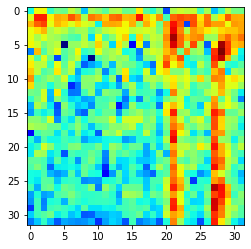

0


In [48]:
for i in range(100,110):
    visualize_spec(train_df, i)

### Вычисление параметров стандартизации данных

In [49]:
research_dataset = AVADataset(train_df, 0, 1)
research_data_loader = DataLoader(research_dataset, batch_size=32, shuffle=True, num_workers=2)

In [50]:
mean, std = get_mean_std(research_data_loader)

In [51]:
mean, std

(-3.052366018295288, 2.4621522426605225)

### Создание dataloaders для всех датасетов

In [52]:
train_df, valid_df = train_test_split(train_df, test_size=0.1, random_state=42)
train_df.reset_index(drop=True, inplace=True)
valid_df.reset_index(drop=True, inplace=True)

#mean=-3.052366018295288
#std=2.4621522426605225
train_dataset = AVADataset(train_df, mean, std)
valid_dataset = AVADataset(valid_df, mean, std)
test_dataset = AVADataset(test_df, mean, std)

train_data_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
valid_data_loader = DataLoader(valid_dataset, batch_size=32, shuffle=True, num_workers=2)
test_data_loader = DataLoader(test_dataset, batch_size=32, shuffle=True, num_workers=2)

print(f'Images for train: {train_df.shape[0]}, images for validation: {valid_df.shape[0]}, images for test: {test_df.shape[0]}')

Images for train: 159240, images for validation: 17694, images for test: 44234


### Создание модели

In [53]:
model = ModelVad()
model_wrapper = ModelWrapper(model=model)
summary(model_wrapper.model, input_size=(32, 1, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
ModelVad                                 --                        --
├─Conv2d: 1-1                            [32, 32, 28, 28]          832
├─MaxPool2d: 1-2                         [32, 32, 14, 14]          --
├─Conv2d: 1-3                            [32, 128, 12, 12]         36,992
├─MaxPool2d: 1-4                         [32, 128, 6, 6]           --
├─Linear: 1-5                            [32, 64]                  294,976
├─LSTM: 1-6                              [32, 64, 256]             134,144
├─Linear: 1-7                            [32, 2]                   514
Total params: 467,458
Trainable params: 467,458
Non-trainable params: 0
Total mult-adds (M): 475.51
Input size (MB): 0.13
Forward/backward pass size (MB): 15.35
Params size (MB): 1.87
Estimated Total Size (MB): 17.35

In [54]:
learning_rate = 0.005
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 
scheduler = ExponentialLR(optimizer, gamma=0.95)
metric = metrics.roc_auc_score
criterion = torch.nn.BCELoss()

### Обучение

In [ ]:
result_train = model_wrapper.fit(criterion,
             metric,
             optimizer,
             scheduler,
             train_data_loader,
             valid_data_loader,
             epochs=10,
             verbose=10)

In [56]:
model_wrapper.save('/Users/igorfrolkin/Downloads/vad_model2_1.pth')

# После 10 эпох обучения

In [57]:
result_train

{'epoch_train_losses': [0.41083643706850387,
  0.36607636864917786,
  0.3568327997971879,
  0.3527680746963974,
  0.34883408695579127,
  0.34648330359662993,
  0.34355734193932225,
  0.34244269511056324,
  0.339041464253796,
  0.3343882948857775],
 'epoch_valid_losses': [0.3669183028568842,
  0.35143945446982305,
  0.3557881670608227,
  0.3908655887863735,
  0.3514752438389587,
  0.3479071766892566,
  0.3587289160592431,
  0.34907077576217344,
  0.34683770853453477,
  0.3435025591585132],
 'epoch_valid_metrics': [0.9109991516108409,
  0.9183640009451197,
  0.9167367080374482,
  0.9170941038129641,
  0.9178856436097865,
  0.9193286276072922,
  0.9183474056875508,
  0.9188549943286253,
  0.920882720132139,
  0.9231276497057093]}

In [68]:
result_train_10_epoch = result_train.copy()

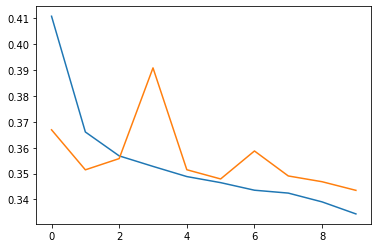

In [101]:
plt.plot(result_train_10_epoch['epoch_train_losses'])
plt.plot(result_train_10_epoch['epoch_valid_losses'])

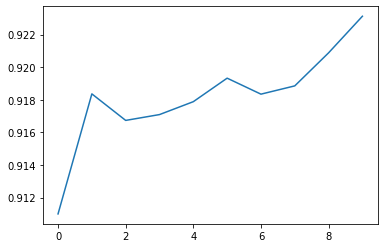

In [102]:
plt.plot(result_train_10_epoch['epoch_valid_metrics'])

In [58]:
y_true, y_proba = test_result(model, test_data_loader, criterion, metric)

{'test_loss': 0.3415502811999573, 'test_metric': 0.923768188098981}


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:24: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:25: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


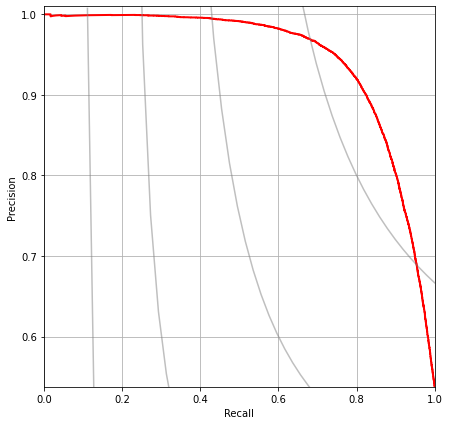

In [66]:
plot_precision_recall(y_true, y_proba)

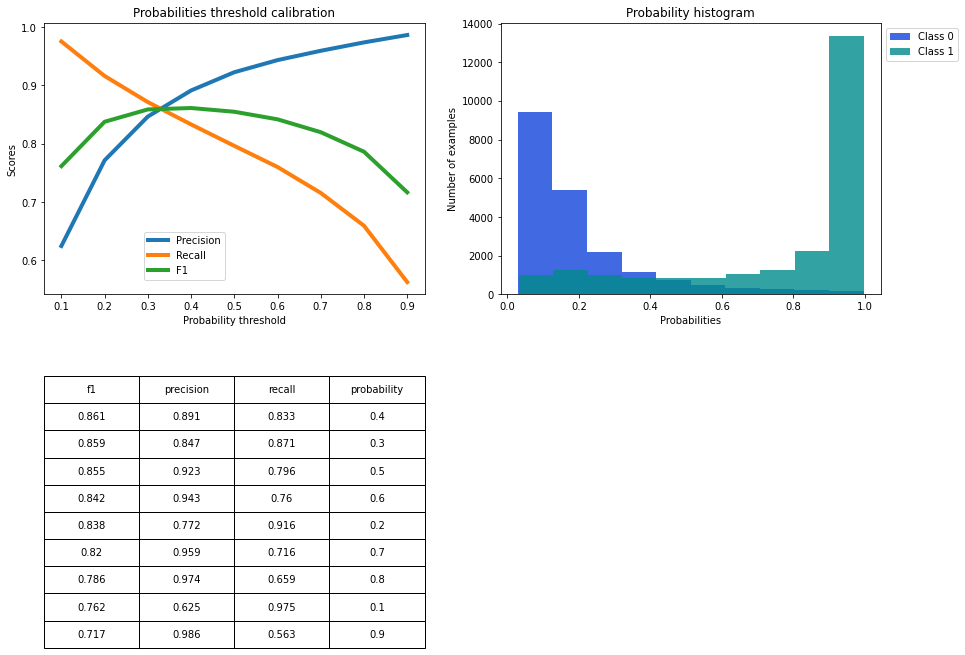

In [67]:
show_proba_calibration_plots(y_proba, y_true)

In [76]:
report(y_true, y_proba, 0.4)

              precision    recall  f1-score   support

           0       0.82      0.88      0.85     20455
           1       0.89      0.83      0.86     23779

    accuracy                           0.86     44234
   macro avg       0.86      0.86      0.86     44234
weighted avg       0.86      0.86      0.86     44234

---------------
Матрица ошибок:
[[18040  2415]
 [ 3968 19811]]
---------------
Правильно предсказано 0: 18040
Правильно предсказано 1: 19811
Ложноотрицательных (FN, ош2р, пропуск события): 3968
Ложноположительных (FP, ош1р, ложная  тревога): 2415
Всего ошибок: 6383


# После 15 эпох обучения

In [ ]:
result_train = model_wrapper.fit(criterion,
             metric,
             optimizer,
             scheduler,
             train_data_loader,
             valid_data_loader,
             epochs=3,
             verbose=10)

In [105]:
model_wrapper.save('/Users/igorfrolkin/Downloads/vad_model2_2.pth')

In [96]:
result_train_15_epoch = result_train.copy()

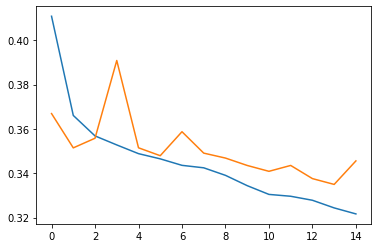

In [98]:
plt.plot(result_train_10_epoch['epoch_train_losses'] + result_train_12_epoch['epoch_train_losses'] + result_train['epoch_train_losses'])
plt.plot(result_train_10_epoch['epoch_valid_losses'] + result_train_12_epoch['epoch_valid_losses'] + result_train['epoch_valid_losses'])

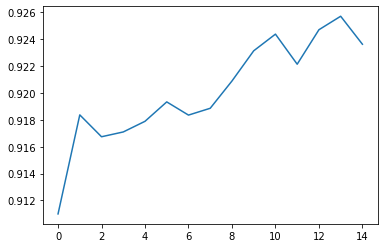

In [99]:
plt.plot(result_train_10_epoch['epoch_valid_metrics'] + result_train_12_epoch['epoch_valid_metrics'] + result_train['epoch_valid_metrics'])

In [100]:
y_true, y_proba = test_result(model, test_data_loader, criterion, metric)

{'test_loss': 0.34231153279758414, 'test_metric': 0.9246416615463038}


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:24: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:25: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


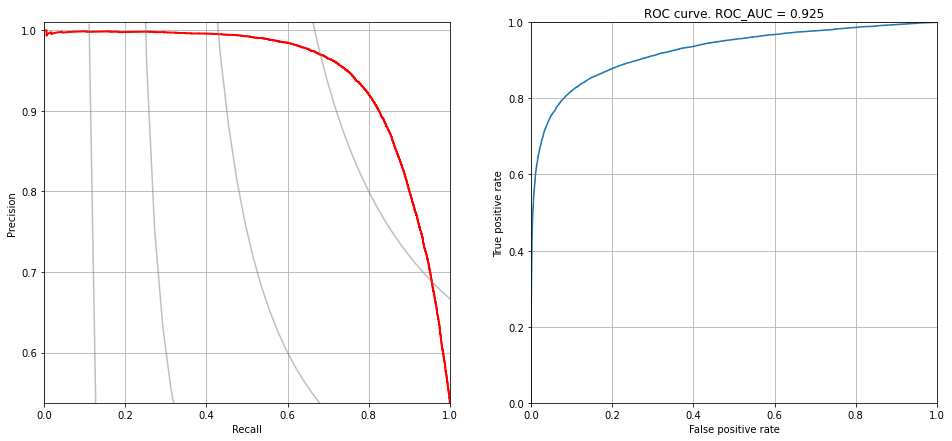

In [124]:
plot_PR_ROC(y_true, y_proba)

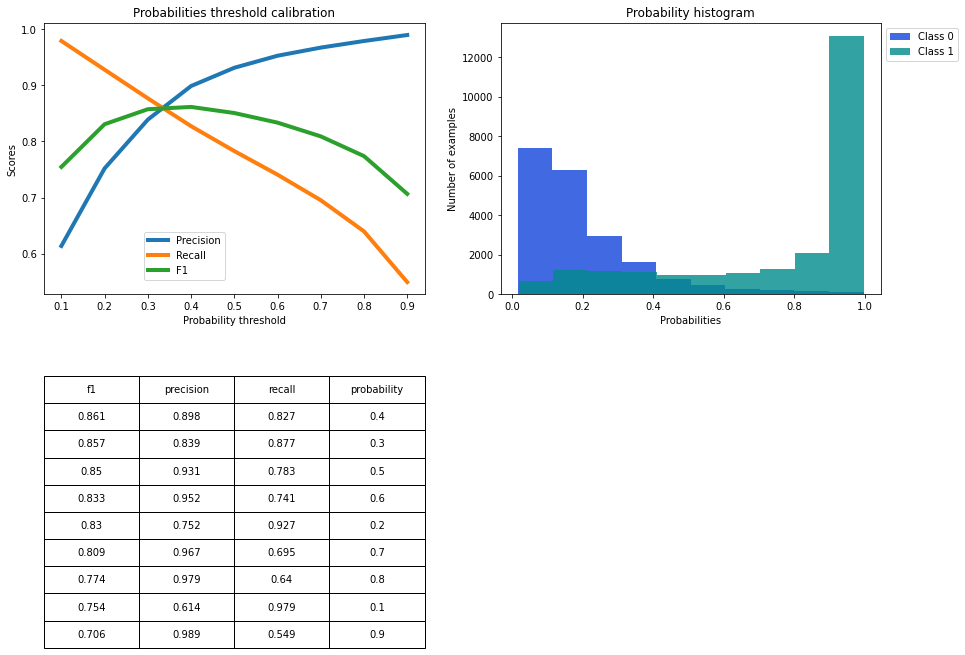

In [104]:
show_proba_calibration_plots(y_proba, y_true)

In [111]:
report(y_true, y_proba, 0.42)

              precision    recall  f1-score   support

           0       0.81      0.90      0.85     20455
           1       0.91      0.82      0.86     23779

    accuracy                           0.86     44234
   macro avg       0.86      0.86      0.86     44234
weighted avg       0.86      0.86      0.86     44234

---------------
Матрица ошибок:
[[18466  1989]
 [ 4341 19438]]
---------------
Правильно предсказано 0: 18466
Правильно предсказано 1: 19438
Ложноотрицательных (FN, ош2р, пропуск события): 4341
Ложноположительных (FP, ош1р, ложная  тревога): 1989
Всего ошибок: 6330
